In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
cwd = os.getcwd()

In [2]:
dataset_details = pd.read_excel(cwd+'/Dataset details.xlsx')
dataset_details.head(dataset_details.shape[0])

,Column,Description
0,cand_id,Candidate identifier
1,job_id,Job position identifier
2,distance_km,Distance (km) between candidate domicile and w...
3,match_score,Score provided by matching algorithm [0-100]. ...
4,direct_match_rank,Rank based on match_score
5,cand_gender,"Candidate gender [Male,Female]"
6,cand_age_bucket,"Candidate age bucket [""15-24"", ""25-34"", ""35-44..."
7,cand_domicile_province,Candidate domicile province abbreviation
8,cand_domicile_region,Candidate domicile region
9,cand_education,Candidate list of educational qualifications


## Direct Matching Dataset

In [3]:
direct_matching_df = pd.read_csv(cwd+'/direct_matching_20240213.csv', sep=';')

In [4]:
direct_matching_df.head()

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,cand_languages_spoken,job_contract_type,job_professional_category,job_sector,job_work_province
0,"5,664,912",OFF_1011_1427,32.327042,99.573387,1,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
1,"4,999,120",OFF_1011_1427,15.595593,99.210564,2,Male,35-44,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
2,"5,413,671",OFF_1011_1427,31.348877,99.118614,3,Female,45-54,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
3,"5,965,090",OFF_1011_1427,66.315598,97.409767,4,Male,15-24,TS,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
4,"5,771,219",OFF_1011_1427,15.595593,97.323875,5,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD


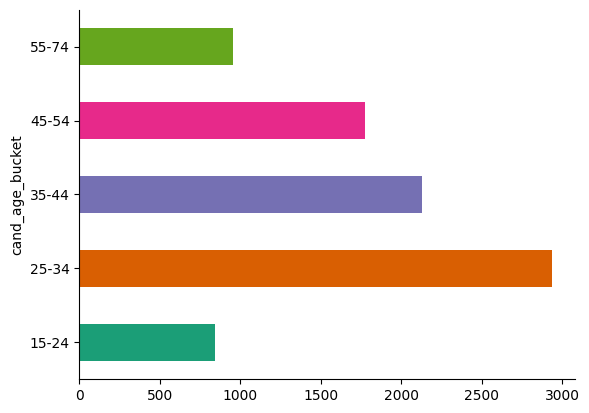

In [ ]:
# @title cand_age_bucket

from matplotlib import pyplot as plt
import seaborn as sns
direct_matching_df.groupby('cand_age_bucket').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

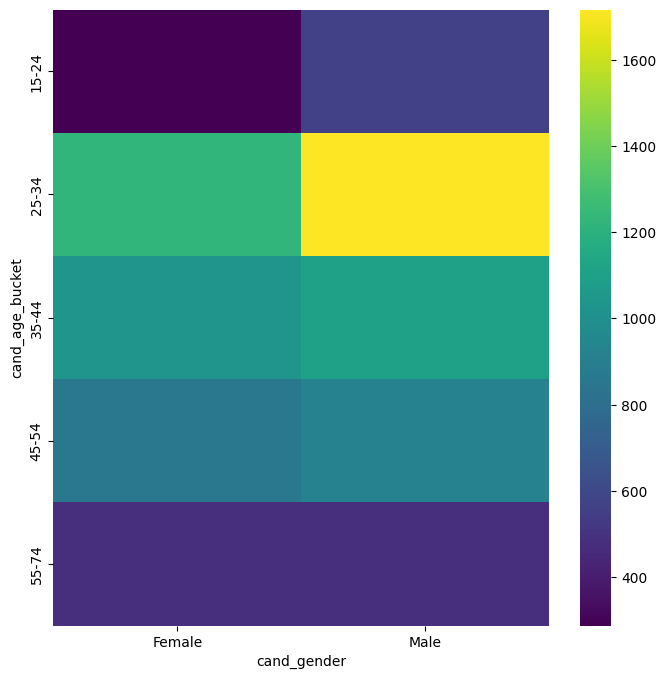

In [ ]:
# @title cand_gender vs cand_age_bucket

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['cand_age_bucket'].value_counts()
    for x_label, grp in direct_matching_df.groupby('cand_gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('cand_gender')
_ = plt.ylabel('cand_age_bucket')

In [5]:
direct_matching_df.describe(include="all")

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,cand_languages_spoken,job_contract_type,job_professional_category,job_sector,job_work_province
count,8647,8647,8647.000000,8647.000000,8647.000000,8647,8646,8644,8642,2341,2355,8647,8647,8647,8647
unique,6798,865,NaN,NaN,NaN,2,5,79,18,433,96,3,247,26,53
top,"6,550,205",OFF_1011_1427,NaN,NaN,NaN,Male,25-34,MI,LOMBARDIA,Licenza media,Rumeno,Lavoro subordinato,Operaio Generico Metalmeccanico,Operai Generici,MI
freq,18,10,NaN,NaN,NaN,4766,2936,1341,3989,433,821,5658,770,2829,1689
mean,NaN,NaN,29.769432,99.633988,5.499480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,23.493063,1.071380,2.872447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,69.610825,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,12.253924,99.676991,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,23.447361,99.856033,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,41.754654,99.932602,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fill NaN with some default values just to test bias

In [6]:
direct_matching_df['cand_languages_spoken'] = direct_matching_df['cand_languages_spoken'].fillna('Italiano')
direct_matching_df['cand_education'] = direct_matching_df['cand_education'].fillna('no education')

In [7]:
mask_candidates_w_edu = direct_matching_df['cand_education'].isnull()
mask_candidates_w_lang = direct_matching_df['cand_languages_spoken'].isnull()

equal = 0
for education,language in zip(mask_candidates_w_edu,mask_candidates_w_lang):
  if education and education == language:
    equal+=1
print(f"candidates without education and language {equal}")
print(f"candidates without education {mask_candidates_w_edu.sum()}")
print(f"candidates without language {mask_candidates_w_lang.sum()}")

candidates without education and language 0
candidates without education 0
candidates without language 0


In [8]:
def get_series_for_column(dataframe,name_col):
  return dataframe[name_col].value_counts()

In [9]:
candidates_with_education = direct_matching_df[~mask_candidates_w_edu]
gender_with_edu = get_series_for_column(candidates_with_education,"cand_gender")
gender_without_edu = get_series_for_column(direct_matching_df[mask_candidates_w_edu],"cand_gender")
gender_with_edu,gender_without_edu

(cand_gender
 Male      4766
 Female    3881
 Name: count, dtype: int64,
 Series([], Name: count, dtype: int64))

# Preprocessing Direct Matching Dataframe
Possible struct dictionary cand_education:
- key: row number
- value: tuple(title)

In [10]:
education_mapping = {
    'no education' : 0,
    'licenza elementare': 1,
    'elementari': 2,
    'licenza media': 3,
    'diploma / accademia': 4,
    'qualifica / attestato': 5,
    'istituto tecnico superiore (its)': 6,
    'laurea triennale': 7,
    'master universitario': 8,
    'laurea magistrale': 9,
    'dottorato di ricerca': 10,
}

reverse_education_mapping = {value: key for key, value in education_mapping.items()}

education_counter_total = {}
education_counter_max = {}
for edu in education_mapping.keys():
  education_counter_max[edu] = 0
  education_counter_total[edu] = 0

In [11]:
df_without_nulls = direct_matching_df.dropna()

education_lvl = df_without_nulls.cand_education
row_to_education = {}
set_education = set()

### Dictionary containing row in which the candidate appear-education ###
for idx,edu in education_lvl.items():
  if ";" in edu:
    qualifications = edu.split(";")
  else:
    qualifications = [edu]
  title = []
  for level in qualifications:
    if ":" in level:

      new_value = level.split(":")[0].strip().lower()
    else:
      new_value = level.strip().lower()
    title.append(new_value)
    set_education.add(new_value)

    #For counting
    education_counter_total[new_value] += 1
    #field.append(level.split(":")[1])

  row_to_education[idx] = title #(title,field)
#for i in row_to_education.values():
#  print(i)

### The loop below is used to retain only the highest education in the CV according to the dictionary above (may be wrong) ###
for row, education in row_to_education.items():
  mapped_value = []
  if len(education) > 1:
    for title in education:
      mapped_value.append(education_mapping[title])
    max_lvl_education = max(mapped_value)
    new_education = reverse_education_mapping[max_lvl_education]

    education_counter_max[new_education] += 1
    row_to_education[row] = [new_education]
  else:
    education_counter_max[education[0]] += 1

education_counter_total['licenza elementare'] += education_counter_total['elementari']
del education_counter_total['elementari']  # same name for the 2 values

education_counter_max['licenza elementare'] += education_counter_max['elementari']
del education_counter_max['elementari']

In [12]:
education_counter_total,sum(education_counter_max.values())

({'no education': 6298,
  'licenza elementare': 22,
  'licenza media': 504,
  'diploma / accademia': 1138,
  'qualifica / attestato': 507,
  'istituto tecnico superiore (its)': 169,
  'laurea triennale': 182,
  'master universitario': 33,
  'laurea magistrale': 200,
  'dottorato di ricerca': 5},
 8639)

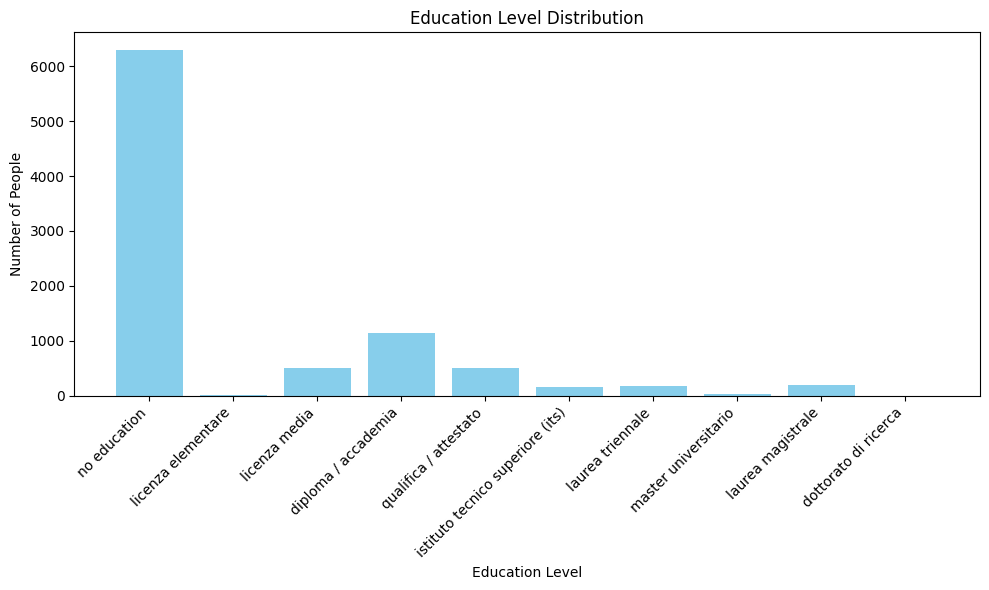

In [13]:
education_levels = list(education_counter_total.keys())
count_values = list(education_counter_total.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(education_levels, count_values, color='skyblue')
plt.xlabel('Education Level')
plt.ylabel('Number of People')
plt.title('Education Level Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

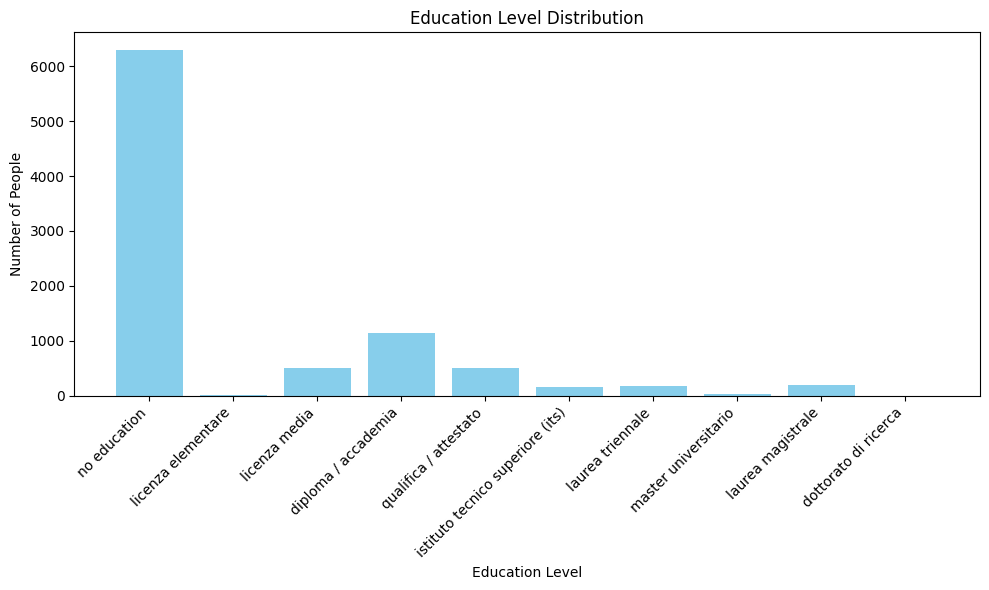

In [14]:
education_levels = list(education_counter_total.keys())
count_values = list(education_counter_total.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(education_levels, count_values, color='skyblue')
plt.xlabel('Education Level')
plt.ylabel('Number of People')
plt.title('Education Level Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Languages

In [15]:
languages_spoken = df_without_nulls.cand_languages_spoken
counter_languages = {}
set_languages = set()
### Dictionary containing row in which the candidate appear-language ###
for idx,langs in languages_spoken.items():
  if ";" in langs:
    languages = langs.split(";")
  else:
    languages = [langs]

  for lang in languages:
      new_lang = lang.strip().lower()
      set_languages.add(new_lang)
      if new_lang in counter_languages:
        counter_languages[new_lang] += 1
      else:
        counter_languages[new_lang] = 1

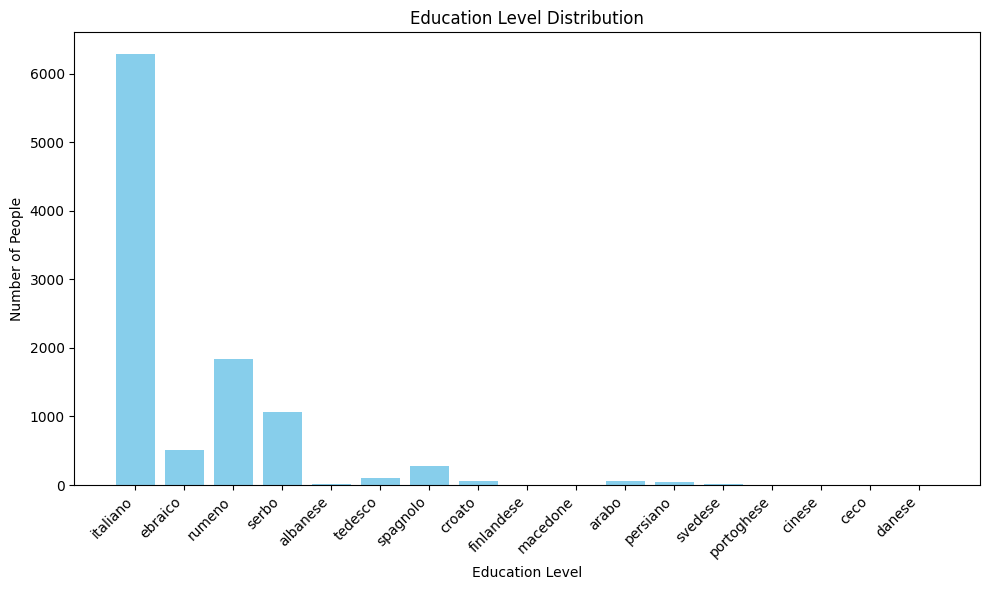

In [16]:
languages_levels = list(counter_languages.keys())
count_languages = list(counter_languages.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(languages_levels, count_languages, color='skyblue')
plt.xlabel('Education Level')
plt.ylabel('Number of People')
plt.title('Education Level Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
print('Number of unique jobs:',direct_matching_df.job_id.nunique())
print('Number of unique candidates:',direct_matching_df.cand_id.nunique()) #some candidates are eligible for more than 1 job

Number of unique jobs: 865
Number of unique candidates: 6798


## Analysis on top x candidates

In [18]:
def get_rank_n_candidates(dataset, match_rank):
  return dataset[dataset['match_rank'] == match_rank]

#best_candidates[best_candidates['cand_gender']=='Male'].shape[0],best_candidates[best_candidates['cand_gender']!='Male'].shape[0]

## Replace education with max level (change this into pandas method)

In [19]:
#df = direct_matching_df.copy()
for idx, edu in row_to_education.items():
  direct_matching_df.cand_education.loc[idx] = edu[0]

Output streaming troncato alle ultime 5000 righe.
<ipython-input-19-c190870705ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct_matching_df.cand_education.loc[idx] = edu[0]
<ipython-input-19-c190870705ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct_matching_df.cand_education.loc[idx] = edu[0]
<ipython-input-19-c190870705ae>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct_matching_df.cand_education.loc[idx]

In [20]:
top_1_cands = get_rank_n_candidates(direct_matching_df,1)
top_2_cands = get_rank_n_candidates(direct_matching_df,2)
top_3_cands = get_rank_n_candidates(direct_matching_df,3)
top_4_cands = get_rank_n_candidates(direct_matching_df,4)
top_5_cands = get_rank_n_candidates(direct_matching_df,5)
top_6_cands = get_rank_n_candidates(direct_matching_df,6)
top_7_cands = get_rank_n_candidates(direct_matching_df,7)
top_8_cands = get_rank_n_candidates(direct_matching_df,8)
top_9_cands = get_rank_n_candidates(direct_matching_df,9)
top_10_cands = get_rank_n_candidates(direct_matching_df,10)

In [21]:
def print_information_top_n_candidates(dataset,columns):
  new_dataset = dataset.drop(columns=['cand_id','job_id','match_rank','match_score'])
  print(f"Shape of the dataset is {new_dataset.shape}")
  for col in columns:
    print(dataset[col].value_counts().sort_values(ascending=False).head(15))

columns = ['distance_km','cand_gender','cand_age_bucket','cand_domicile_region','cand_education']
#print_information_top_n_candidates(top_1_cands,columns)

## Discretization of distances

In [22]:
#print(distances_km.min(),distances_km.max())
def discretize_feature(data):
  distances_km_discrete = np.zeros(10)
  for dist in data:
    distances_km_discrete[int(dist//10)] +=1
  return distances_km_discrete

distances_km = direct_matching_df.distance_km
distances_km = discretize_feature(distances_km)

total_distances = np.sum(distances_km)
dict_distances = {}
for i in range(10):
  dict_distances[i] = np.around(distances_km[i]/total_distances,4)

In [23]:
def create_dictionary_from_series(series): #in percentage
  dict_series = {}
  total = np.sum(series.values)
  for idx, val in zip(series.index,series.values):
    dict_series[idx] = np.around((val/total),4)
  return dict_series

In [24]:
dict_gender = create_dictionary_from_series(direct_matching_df.cand_gender.value_counts())
dict_age = create_dictionary_from_series(direct_matching_df.cand_age_bucket.value_counts())
dict_domicile_region = create_dictionary_from_series(direct_matching_df.cand_domicile_region.value_counts())
dict_job_province = create_dictionary_from_series(direct_matching_df.job_work_province.value_counts())
dict_education = create_dictionary_from_series(direct_matching_df.cand_education.value_counts())

In [25]:
def create_dicts_rank_n(dataset,cols):
  dict_list = []

  ###distance###
  distances_km = discretize_feature(dataset.distance_km)
  total_distances = np.sum(distances_km)
  dict_distances = {}
  for i in range(10):
    dict_distances[i] = np.around(distances_km[i]/total_distances,4)
  dict_list.append(dict_distances)

  for col in cols:
    dict_list.append(create_dictionary_from_series(dataset[col].value_counts()))

  return dict_list

columns = ['cand_gender','cand_age_bucket','cand_domicile_region','job_work_province','cand_education']
top_1_dicts = create_dicts_rank_n(top_1_cands,columns)
top_2_dicts = create_dicts_rank_n(top_2_cands,columns)
top_3_dicts = create_dicts_rank_n(top_3_cands,columns)
top_4_dicts = create_dicts_rank_n(top_4_cands,columns)
top_5_dicts = create_dicts_rank_n(top_5_cands,columns)
top_6_dicts = create_dicts_rank_n(top_6_cands,columns)
top_7_dicts = create_dicts_rank_n(top_7_cands,columns)
top_8_dicts = create_dicts_rank_n(top_8_cands,columns)
top_9_dicts = create_dicts_rank_n(top_9_cands,columns)
top_10_dicts = create_dicts_rank_n(top_10_cands,columns)

full_dicts = [dict_distances,dict_gender,dict_age,dict_domicile_region,dict_job_province,dict_education]

liston = [full_dicts,top_1_dicts,top_2_dicts,top_3_dicts,top_4_dicts,top_5_dicts,top_6_dicts,top_7_dicts,top_8_dicts,top_9_dicts,top_10_dicts]

In [26]:
# Extracting dictionaries from each sublist
def create_table_for_feature(list_dict,idx=0):
  selected_dicts = [sublist[idx] for sublist in list_dict]

  total_keys = selected_dicts[0].keys()
  for dictionary in selected_dicts[1:]:
    for key in total_keys:
      if key not in dictionary.keys():
        dictionary[key] = 0

  data = [list(d.values()) for d in selected_dicts]

  return pd.DataFrame(np.vstack(data),columns=list(selected_dicts[0].keys()))

In [27]:
direct_distance_km = create_table_for_feature(liston,idx=0)
direct_gender = create_table_for_feature(liston,idx=1)
direct_age = create_table_for_feature(liston,idx=2)
direct_home_region = create_table_for_feature(liston,idx=3)
direct_job_province = create_table_for_feature(liston,idx=4)
direct_education = create_table_for_feature(liston,idx=5)

# Print single Feature

In [28]:
def print_feature_distribution(dataframe, title):
  dataframe.plot(kind='bar', stacked=True)
  plt.title(f'Distribution of {title} by Rank')
  plt.xlabel('Rank')
  plt.ylabel('Proportion')
  plt.xticks(rotation=0)
  plt.legend(title=title)
  plt.show()

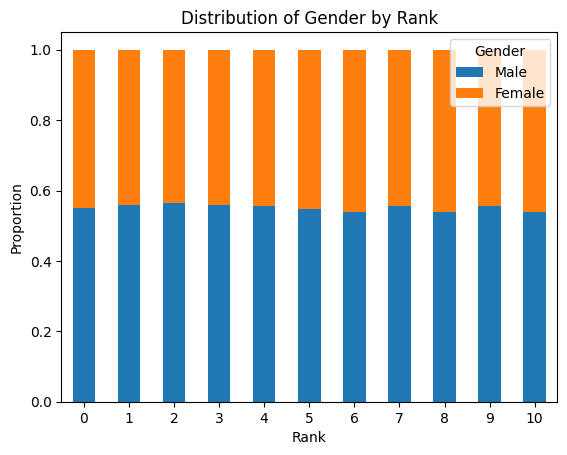

In [29]:
print_feature_distribution(direct_gender,'Gender')

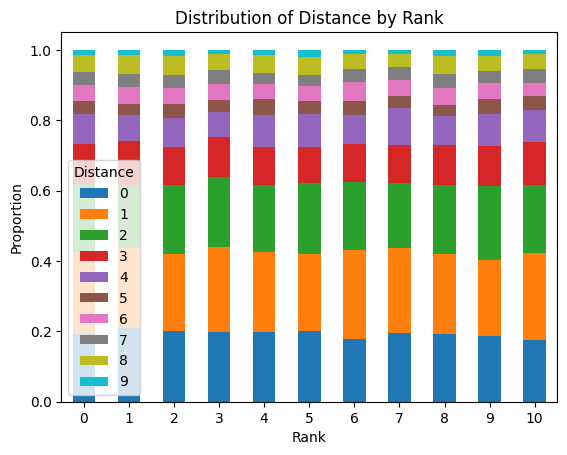

In [30]:
print_feature_distribution(direct_distance_km,'Distance')

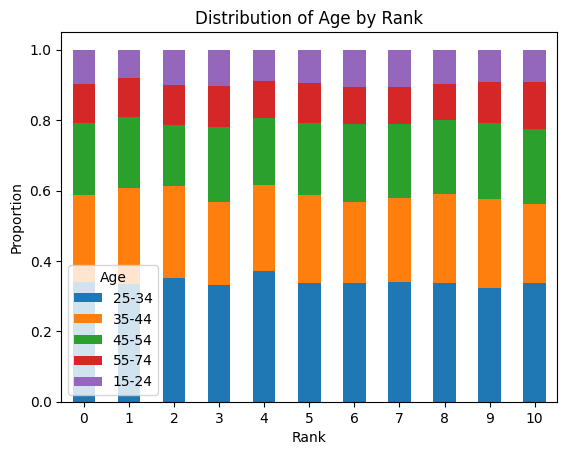

In [31]:
print_feature_distribution(direct_age,'Age')

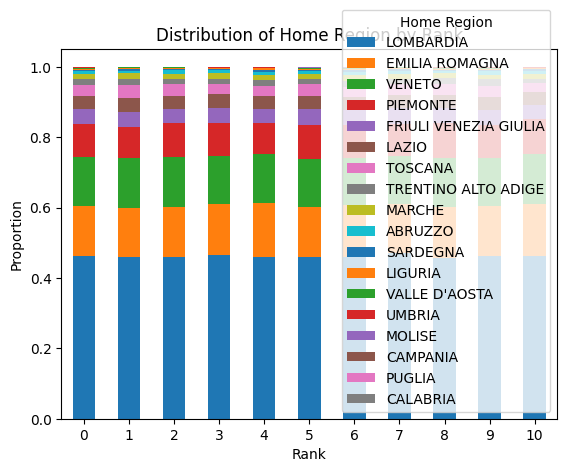

In [32]:
print_feature_distribution(direct_home_region,'Home Region')

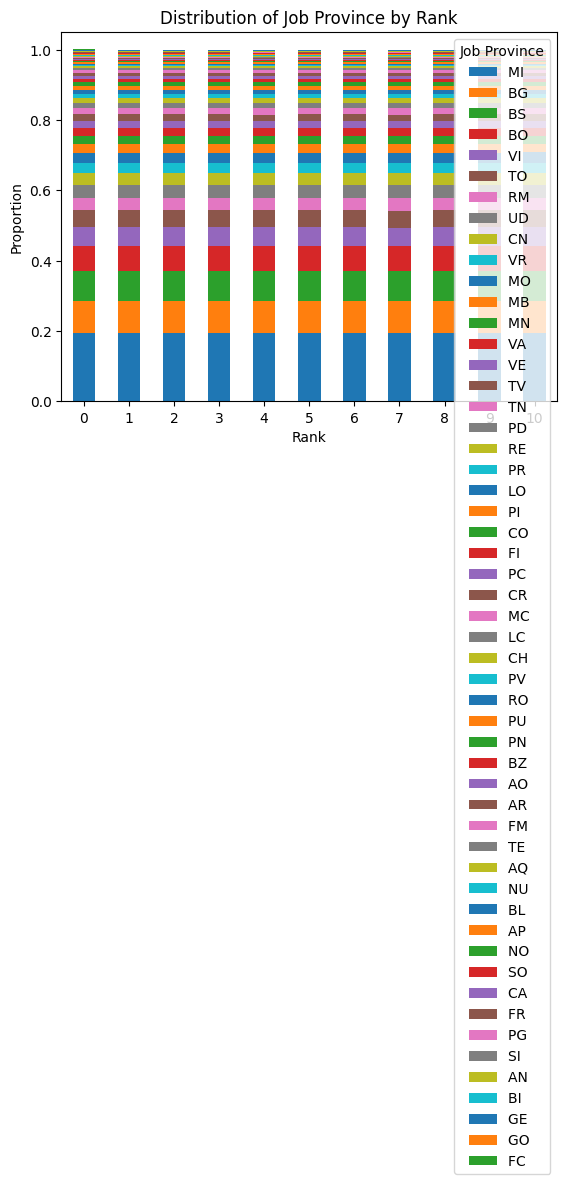

In [33]:
print_feature_distribution(direct_job_province,'Job Province')

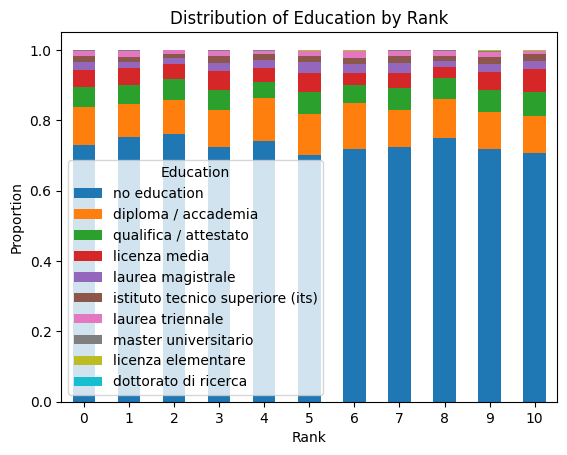

In [34]:
print_feature_distribution(direct_education,'Education')

# Test 2 features together

In [35]:
direct_matching_df = direct_matching_df.dropna()
direct_matching_df['distance_km'] = (direct_matching_df['distance_km'] // 10)

<ipython-input-35-da7d8440770e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct_matching_df['distance_km'] = (direct_matching_df['distance_km'] // 10)


In [36]:
def plot_2_features(df, feature1, feature2, num_ranks=[1,2], num_cols=2, response=None):
    data = []
    if num_ranks == None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)
        distribution = df.groupby(feature1)[feature2].value_counts(normalize=True).unstack()
        data.append(distribution)
        distribution.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(f'Full dataset')
        ax.set_xlabel('')
        ax.set_ylabel('Count')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate x-axis labels if needed
        ax.legend(title=feature2)
        plt.show()
    else:

      fig, axs = plt.subplots(1, num_cols, figsize=(10, 8), constrained_layout=True)
      fig.suptitle(f'{feature1} Distribution by {feature2} for Different Ranks', fontsize=16)
      for i, rank in enumerate(num_ranks):
          if len(num_ranks) == 1:  # Handle single rank differently
              ax = axs
          else:
              ax = axs[i]
          new_df = df[df.match_rank == rank]
          distribution = new_df.groupby(feature1)[feature2].value_counts(normalize=True).unstack()
          distribution.plot(kind='bar', stacked=True, ax=ax)
          data.append(distribution)
          ax.set_title(f'Rank {rank}')
          ax.set_xlabel('')
          ax.set_ylabel('Count')
          ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate x-axis labels if needed
          ax.legend(title=feature2)

      plt.show()

    if response != None:
      return data

### Gender & Education

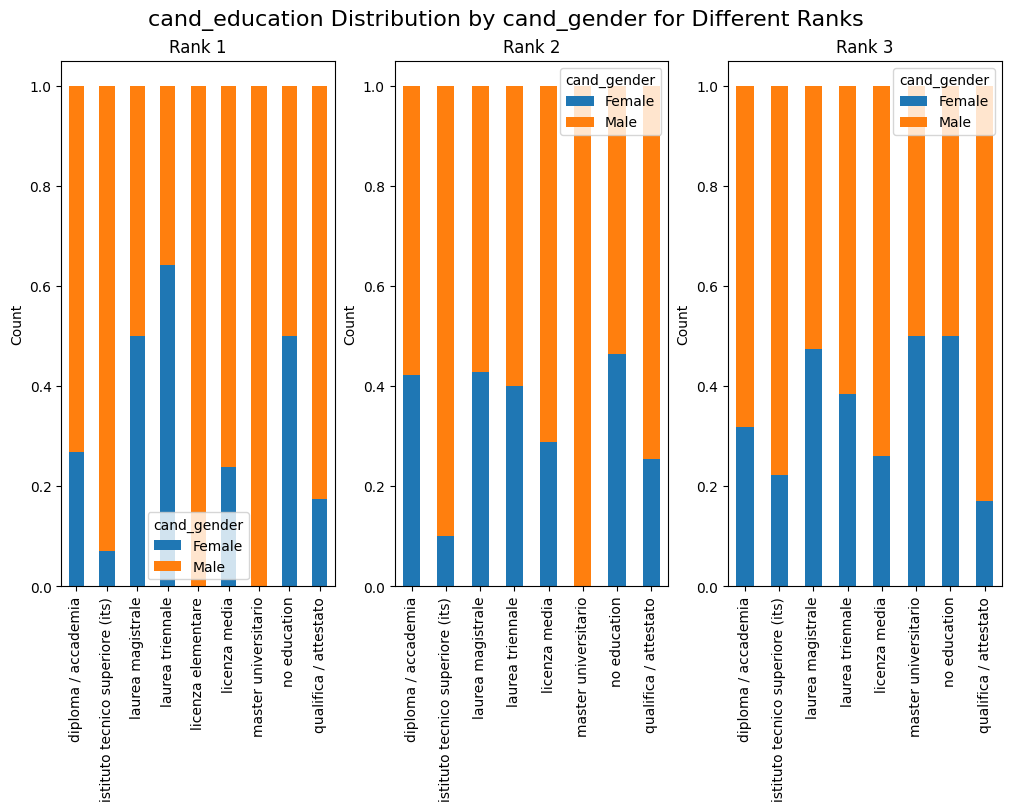

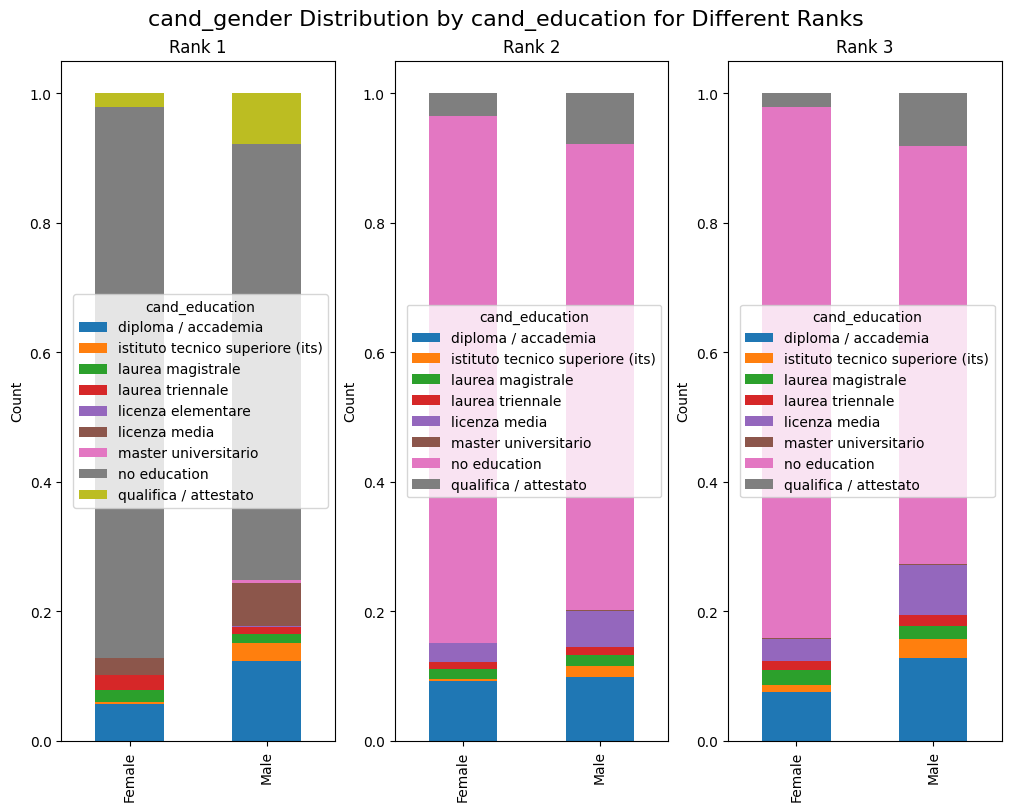

In [ ]:
r = [1,2,3]
plot_2_features(direct_matching_df,'cand_education','cand_gender',r,len(r))
plot_2_features(direct_matching_df,'cand_gender','cand_education',r,len(r))

### Gender & distance

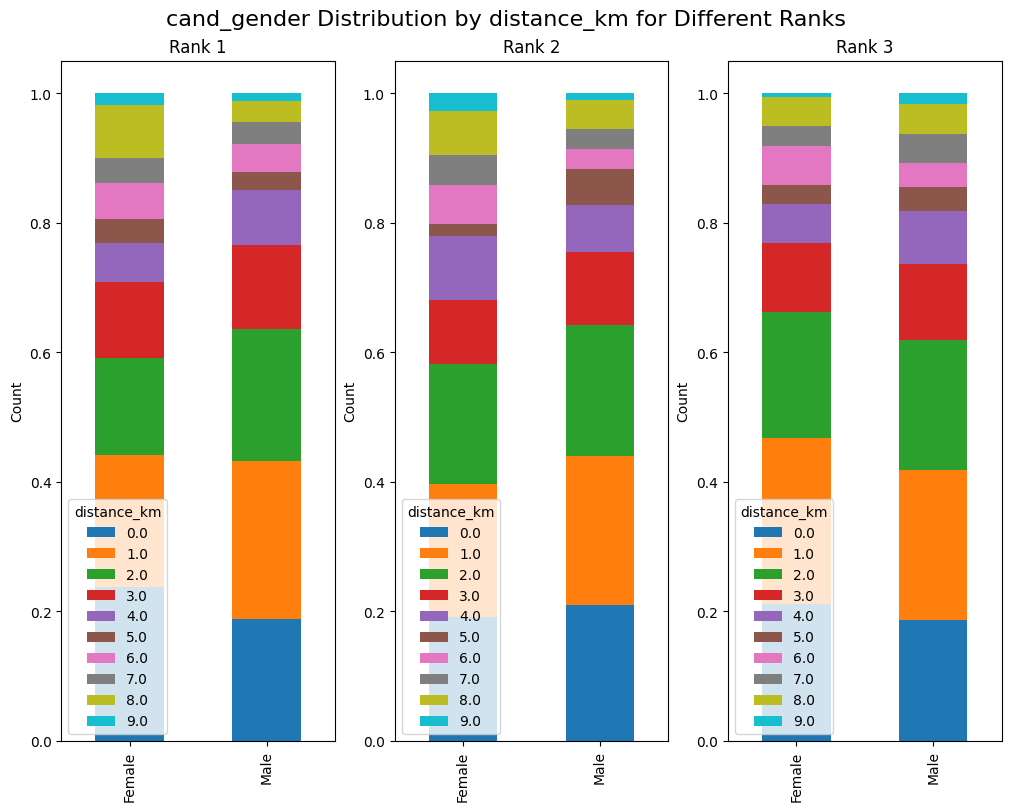

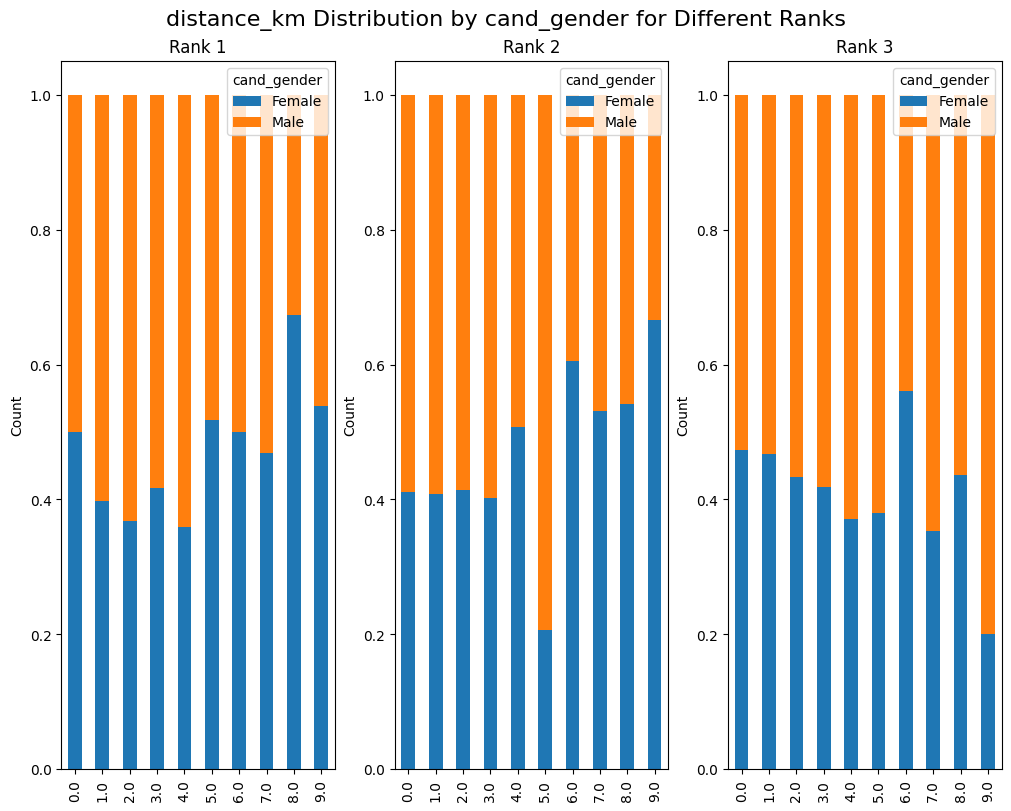

In [37]:
r = [1,2,3]
plot_2_features(direct_matching_df.dropna(),'cand_gender','distance_km',r,len(r))
plot_2_features(direct_matching_df.dropna(),'distance_km','cand_gender',r,len(r))

### Gender & Age

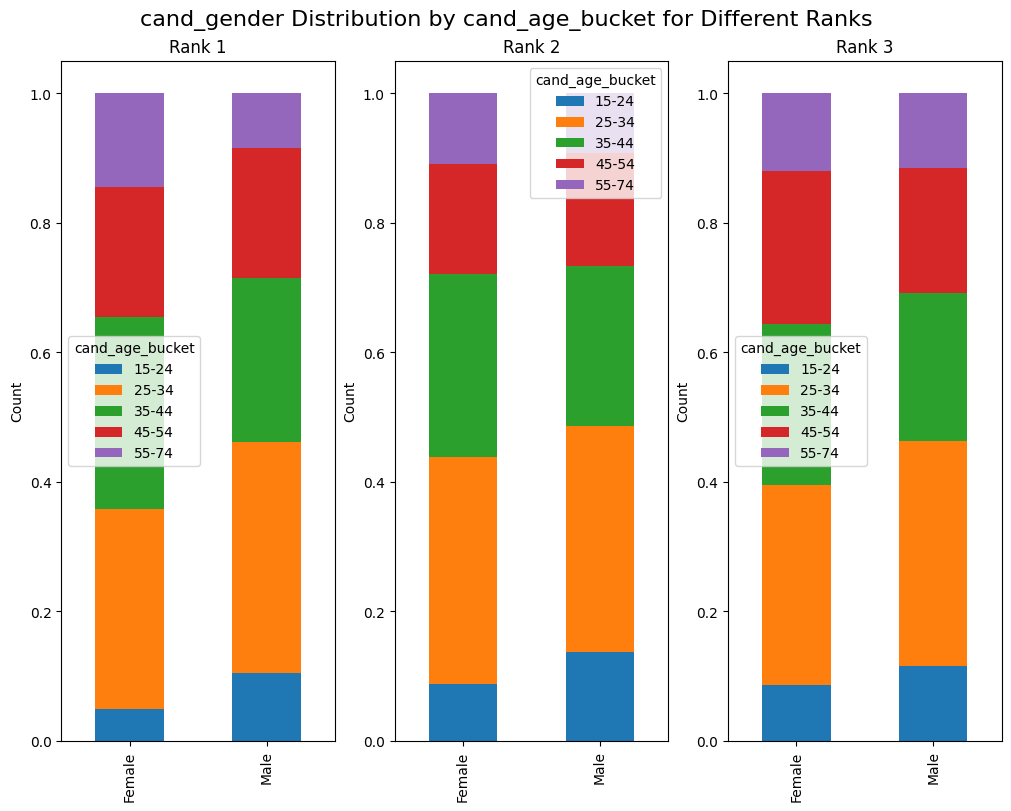

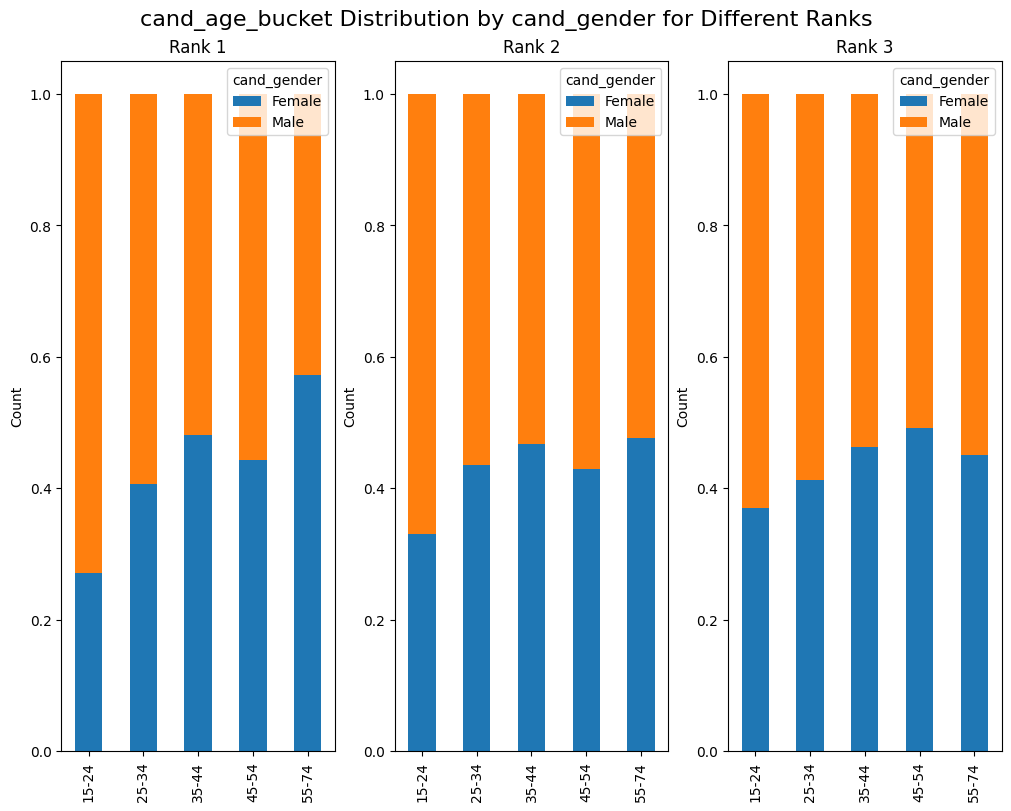

In [38]:
r = [1,2,3]
plot_2_features(direct_matching_df.dropna(),'cand_gender','cand_age_bucket',r,len(r))
plot_2_features(direct_matching_df.dropna(),'cand_age_bucket','cand_gender',r,len(r))

### Education & Age

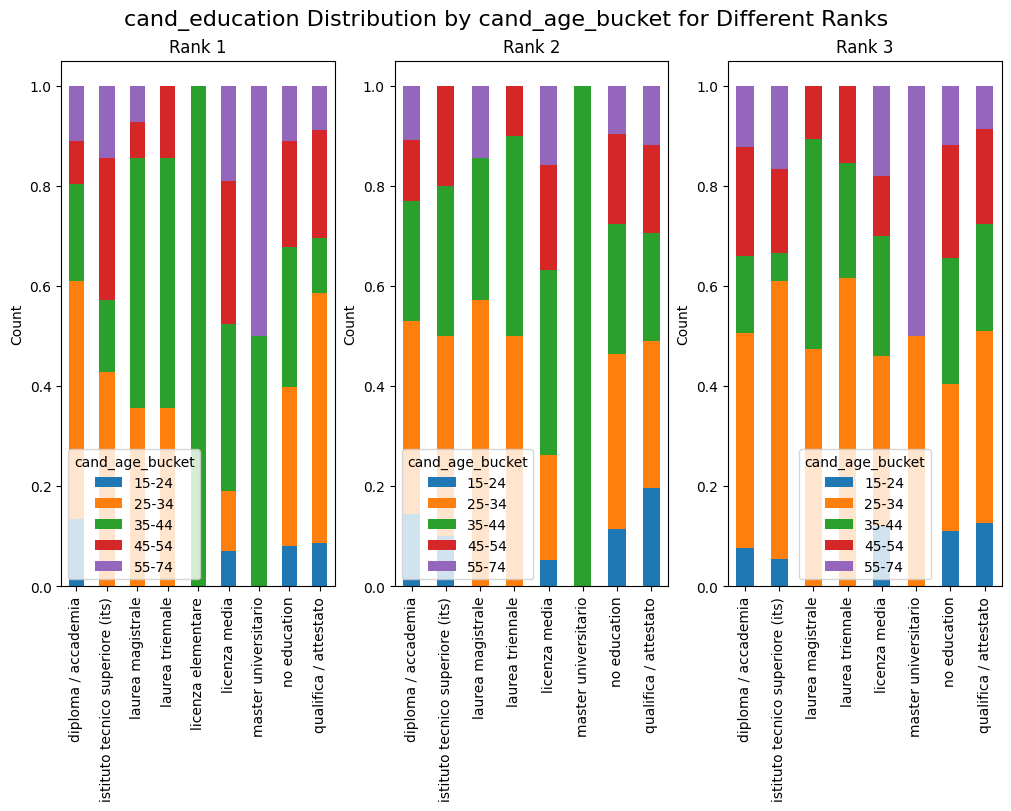

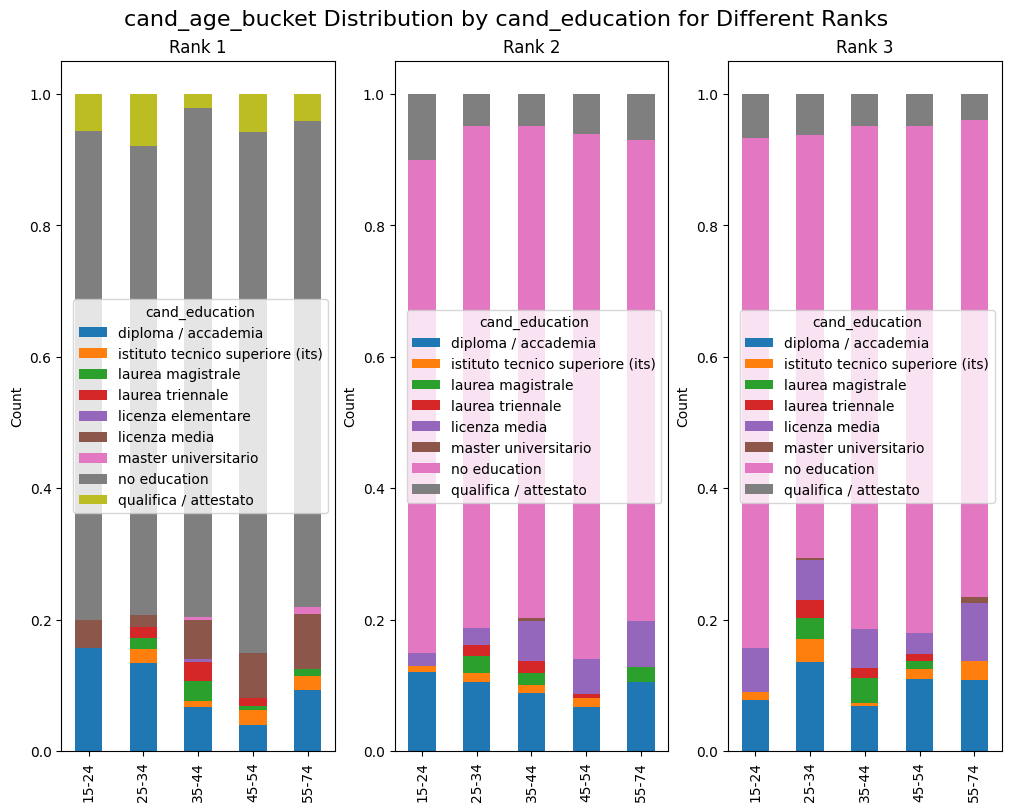

In [39]:
r = [1,2,3]
plot_2_features(direct_matching_df.dropna(),'cand_education','cand_age_bucket',r,len(r))
plot_2_features(direct_matching_df.dropna(),'cand_age_bucket','cand_education',r,len(r))

### Education & Distance

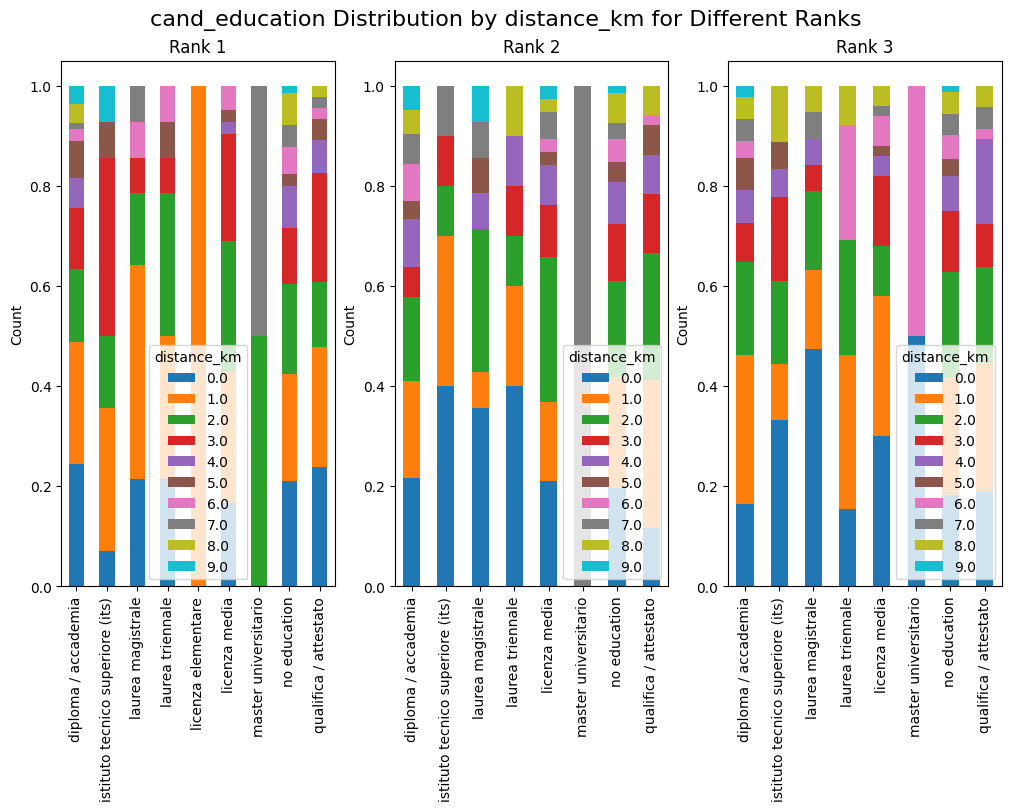

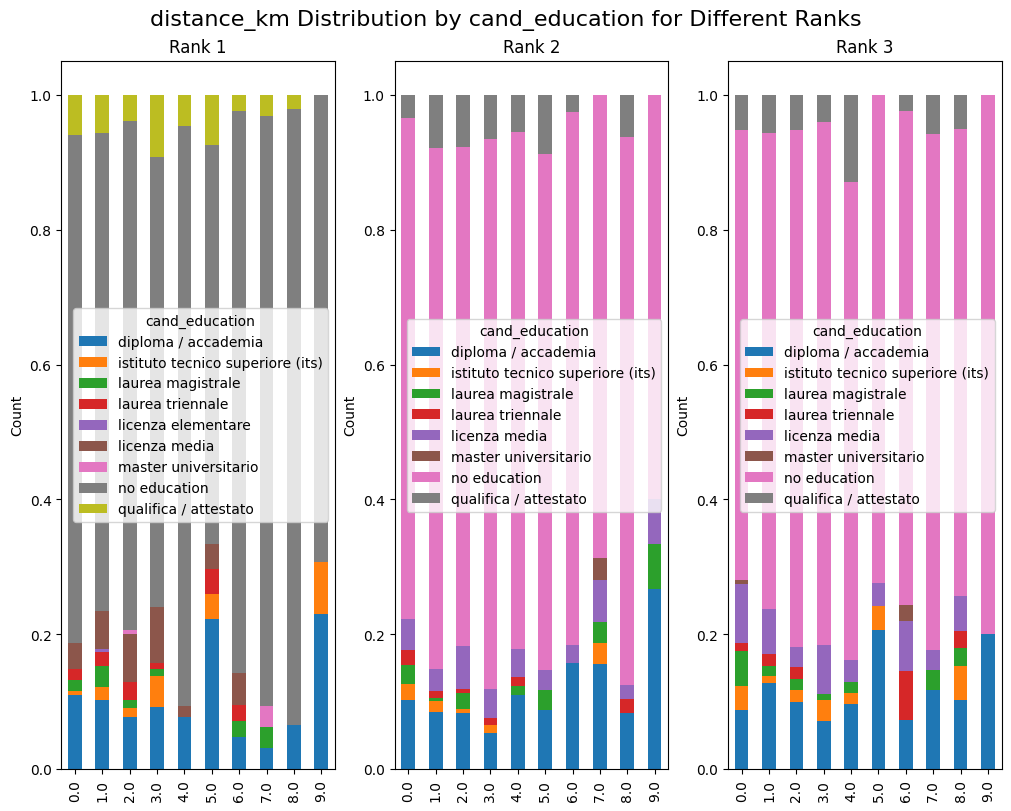

In [40]:
r = [1,2,3]
plot_2_features(direct_matching_df.dropna(),'cand_education','distance_km',r,len(r))
plot_2_features(direct_matching_df.dropna(),'distance_km','cand_education',r,len(r))

 ### Age and Distance

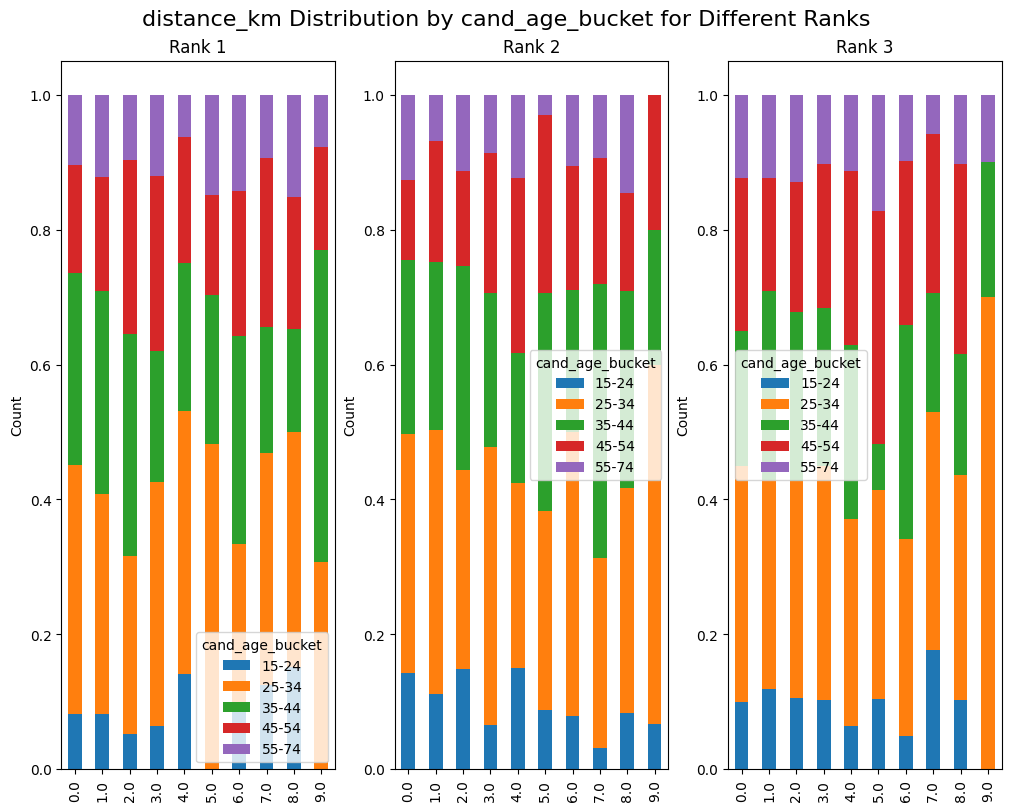

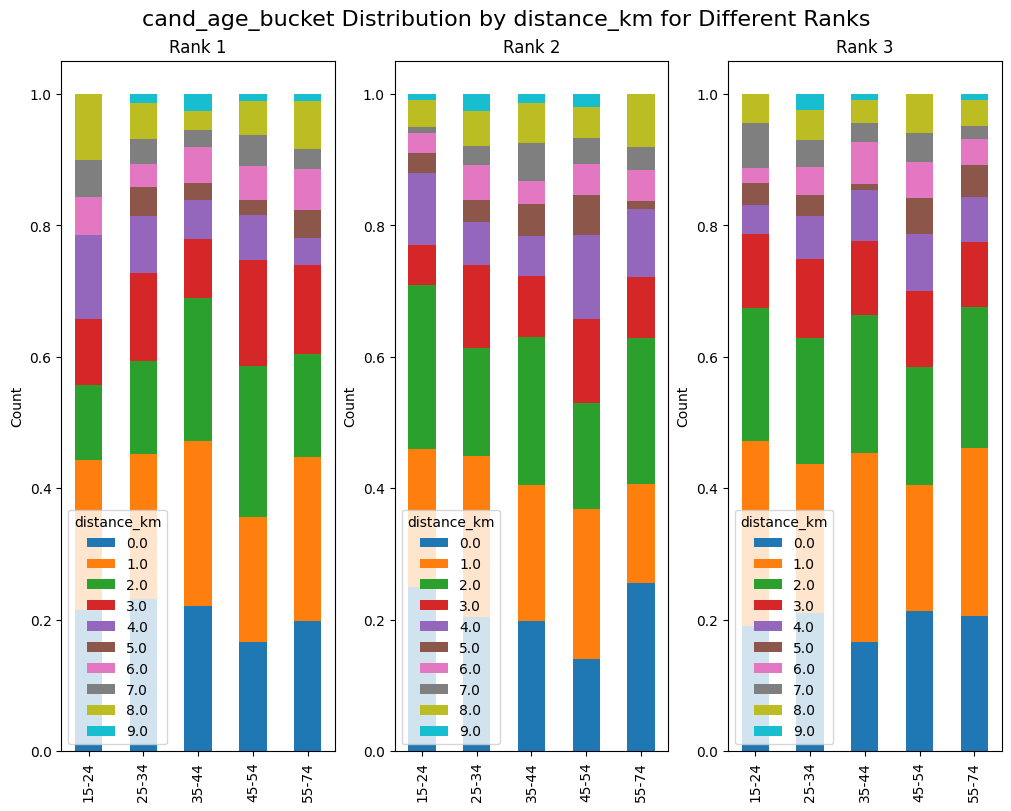

In [41]:
r = [1,2,3]
plot_2_features(direct_matching_df.dropna(),'distance_km','cand_age_bucket',r,len(r))
plot_2_features(direct_matching_df.dropna(),'cand_age_bucket','distance_km',r,len(r))

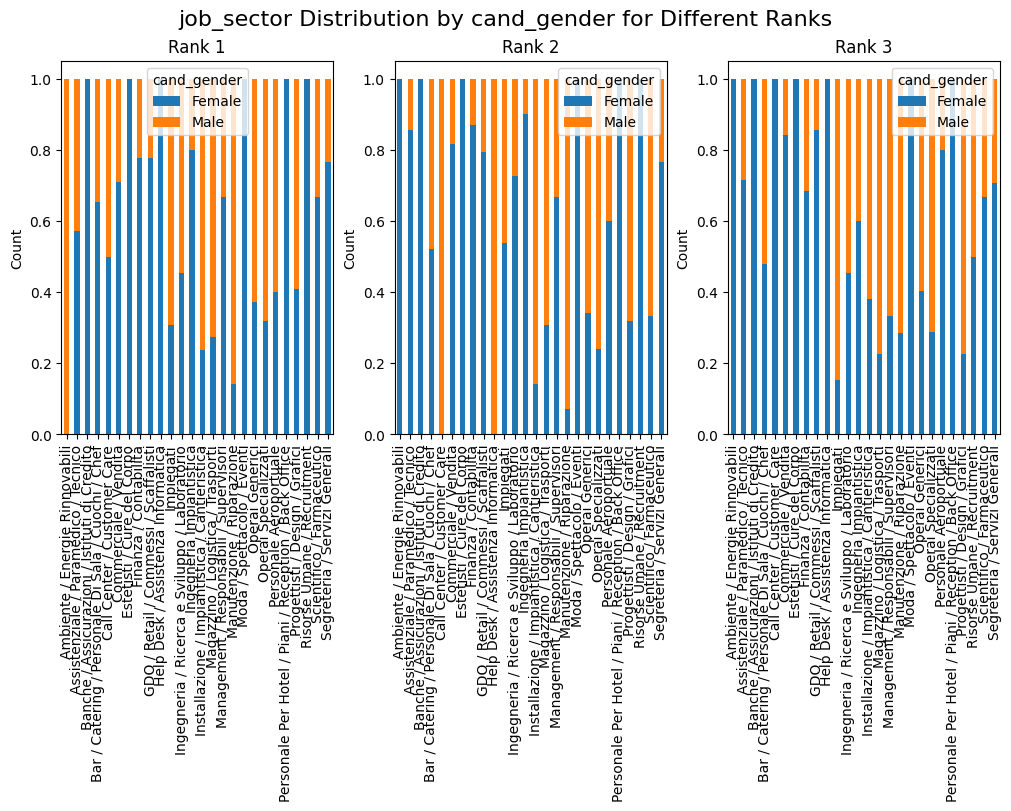

In [42]:
r = [1,2,3]
#plot_2_features(direct_matching_df.dropna(),'cand_gender','job_sector',r,len(r))
plot_2_features(direct_matching_df.dropna(),'job_sector','cand_gender',r,len(r))

# Check correlation between job_professional_category and job_sector

In [43]:
for sector in direct_matching_df['job_sector'].unique():
    # Filter the DataFrame for the current sector
    sector_df = direct_matching_df[direct_matching_df['job_sector'] == sector]
    # Print the sector
    print(f"Sector: {sector}")
    # Group by 'job_professional_category' and count rows
    category_counts = sector_df['job_professional_category'].value_counts(normalize=True).round(2)
    # Iterate over unique categories
    for category, count in category_counts.items():
        # Print category and count
        print(f"  Category: {category}, Count: {count}")
    print()

Sector: Progettisti / Design / Grafici
  Category: Geometra e tecnico di costruzioni civili e industriali, Count: 0.23
  Category: disegnatore meccanico/disegnatrice meccanica, Count: 0.18
  Category: Impiegato ufficio tecnico, Count: 0.14
  Category: Progettista Industriale, Count: 0.09
  Category: ingegnere edile, Count: 0.05
  Category: Responsabile Progettazione Tecnica, Count: 0.05
  Category: designer grafico/designer grafica, Count: 0.05
  Category: Progettista meccanico, Count: 0.05
  Category: ingegnere di prodotto, Count: 0.05
  Category: Disegnatore 3D (m/f), Count: 0.05
  Category: progettista di interni, Count: 0.05
  Category: Disegnatore Tecnico (Costruzioni) (m/f), Count: 0.05

Sector: GDO / Retail / Commessi / Scaffalisti
  Category: commesso di punto vendita/shop assistant, Count: 0.67
  Category: Commesso di supermercato (m/f), Count: 0.11
  Category: Banconista, Count: 0.08
  Category: Macellaio (m/f), Count: 0.02
  Category: Capo Reparto grande distribuzione organi

In [44]:
jobcategories_df = direct_matching_df.dropna().groupby('job_id')['job_professional_category'].value_counts()
for index, value in jobcategories_df.items():
    print(index, value)

('OFF_1011_1427', 'Geometra e tecnico di costruzioni civili e industriali') 10
('OFF_1038_1739', 'Macellaio (m/f)') 10
('OFF_1042_1739', 'Capo Reparto grande distribuzione organizzata') 10
('OFF_104_1550', 'saldatore/saldatrice') 10
('OFF_111_1704', 'Autista di autocarro a portale (m/f)') 10
('OFF_1149_0073', 'magazziniere/magazziniera') 10
('OFF_1149_0288', 'Operaio Generico Edile') 10
('OFF_1151_0073', 'Operatore CNC (m/f)') 10
('OFF_1186_1770', 'Infermiere') 10
('OFF_1204_0354', 'addetto alla lavorazione dei metalli') 10
('OFF_1208_1770', 'O.S.S. (operatore socio sanitario)') 10
('OFF_1209_1770', 'O.S.S. (operatore socio sanitario)') 10
('OFF_1214_0354', 'addetto controllo qualità prodotti') 10
('OFF_1216_0354', 'Meccanico/Attrezzista dispositivi per la saldatura (m/f)') 10
('OFF_1216_1626', 'Tecnico di cantiere') 10
('OFF_1221_1770', 'O.S.S. (operatore socio sanitario)') 10
('OFF_1222_1770', 'O.S.S. (operatore socio sanitario)') 10
('OFF_1233_0263', 'assistente contabile') 10
('OFF

# Reverse Matching

In [45]:
reverse_matching_df = pd.read_csv(cwd+'/reverse_matching_20240213.csv', sep=';')
reverse_matching_df.shape

(193474, 15)

In [46]:
reverse_matching_df.describe(include="all")

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,cand_languages_spoken,job_contract_type,job_professional_category,job_sector,job_work_province
count,193474,193474,193474.000000,193474.000000,193474.000000,193474,193474,190635,193454,70645,71729,193474,192884,192876,169621
unique,21650,14506,NaN,NaN,NaN,2,5,107,20,1683,237,3,1066,42,107
top,"11,208",ORD_3933_1635,NaN,NaN,NaN,Male,25-34,MI,LOMBARDIA,Licenza media,Rumeno,Lavoro subordinato,commesso di punto vendita/shop assistant,Operai Generici,MI
freq,10,1019,NaN,NaN,NaN,97696,72444,20916,63498,5464,26462,99644,6714,22004,33749
mean,NaN,NaN,38.210087,91.837911,2.923726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,27.047254,12.394169,1.416097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,30.001501,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,16.593061,90.506653,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,32.815426,96.752945,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,57.491835,98.881617,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


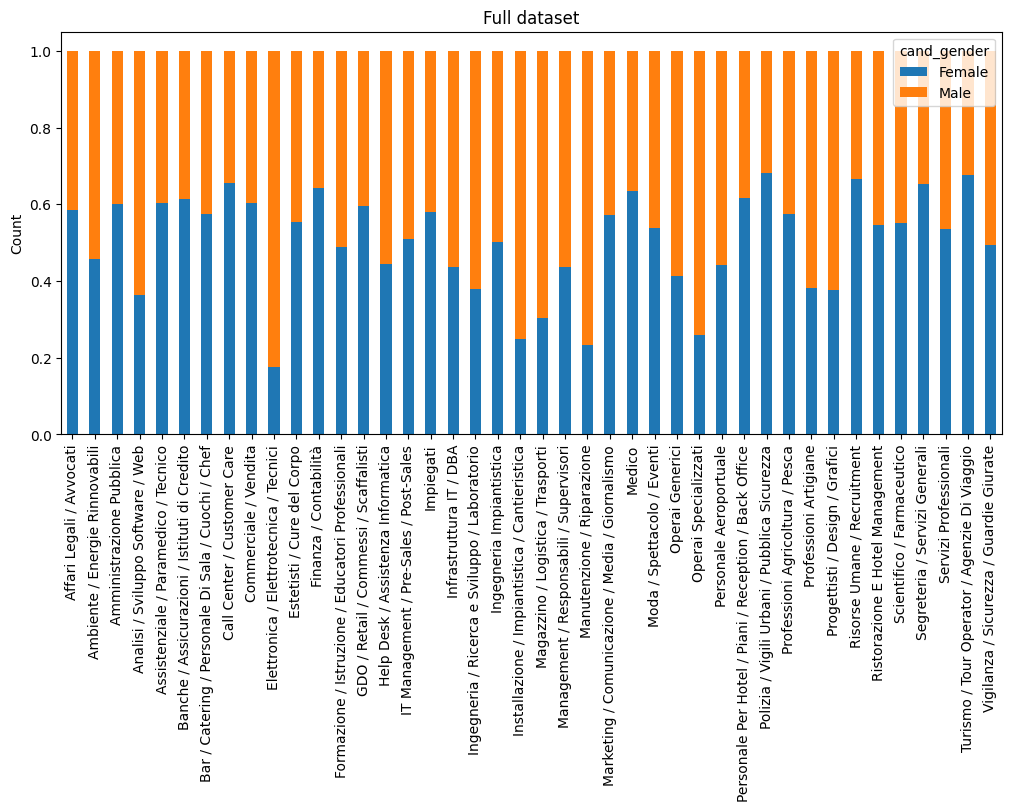

In [47]:
plot_2_features(reverse_matching_df, 'job_sector', 'cand_gender', None)

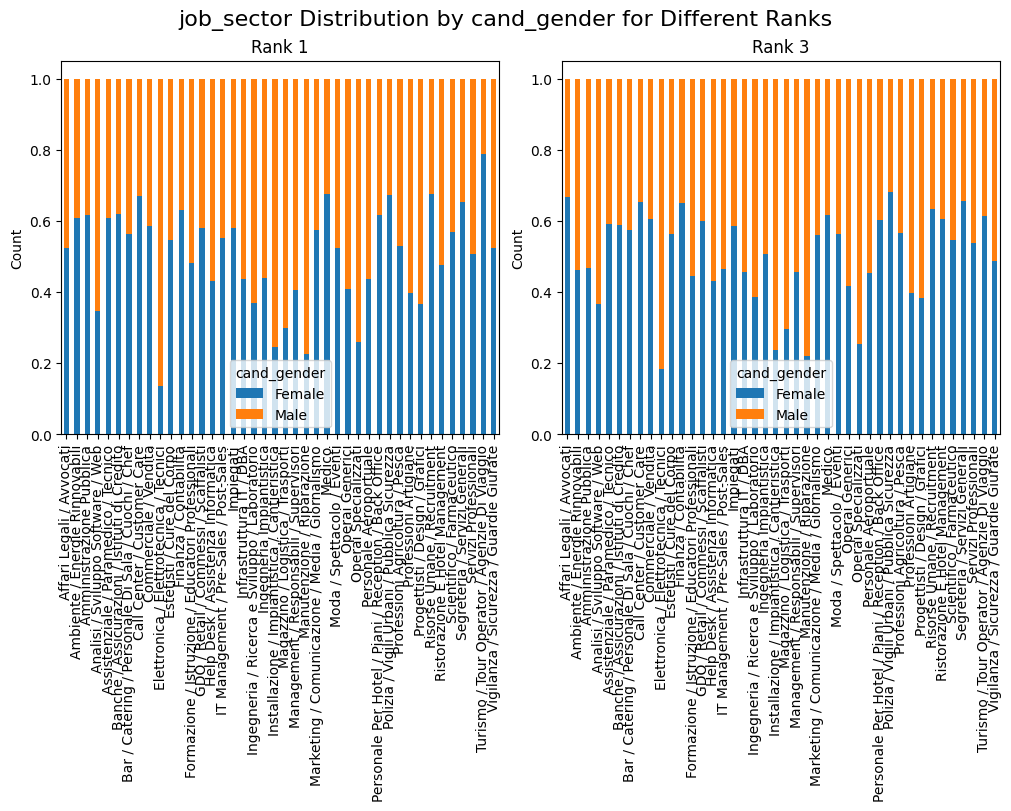

In [48]:
r = [1,3]
data = plot_2_features(reverse_matching_df, 'job_sector', 'cand_gender', r, len(r),response=0)

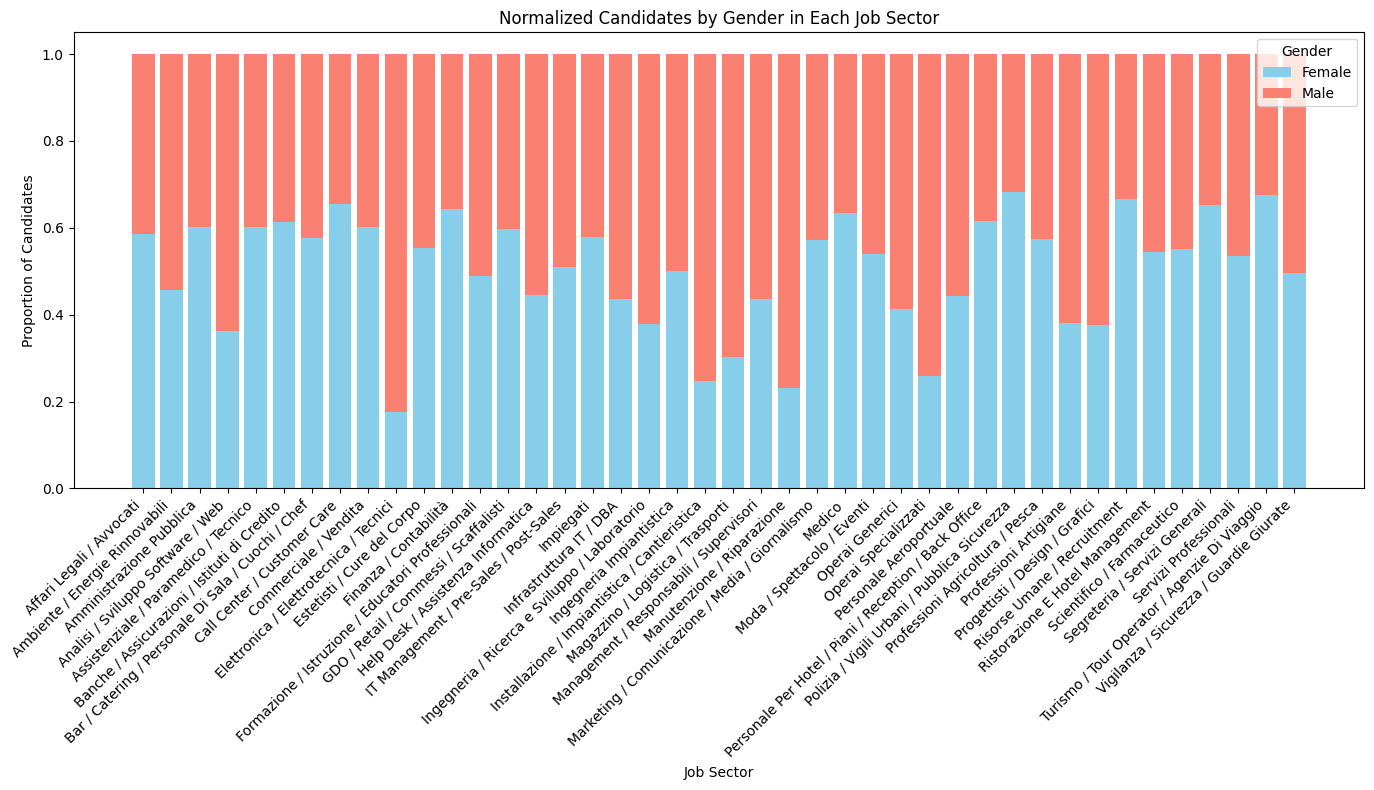

In [ ]:
"""# Calculate the frequency of candidates by gender and job sector
candidates_by_sector_gender = reverse_matching_df.groupby(['job_sector', 'cand_gender']).size().unstack(fill_value=0)

# Calculate the total number of candidates in each job sector
total_candidates_by_sector = candidates_by_sector_gender.sum(axis=1)

# Normalize the data
candidates_by_sector_gender['Female_Normalized'] = candidates_by_sector_gender['Female'] / total_candidates_by_sector
candidates_by_sector_gender['Male_Normalized'] = candidates_by_sector_gender['Male'] / total_candidates_by_sector

# Visualize the data
plt.figure(figsize=(14, 8))

# Iterate through each job sector
for index, row in candidates_by_sector_gender.iterrows():
    plt.bar(index, row['Female_Normalized'], color='skyblue')
    plt.bar(index, row['Male_Normalized'], bottom=row['Female_Normalized'], color='salmon')

# Add legend outside the loop
plt.legend(['Female', 'Male'], title='Gender', loc='upper right')

plt.title('Normalized Candidates by Gender in Each Job Sector')
plt.xlabel('Job Sector')
plt.ylabel('Proportion of Candidates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()"""